In [17]:
import numpy as np
import scipy.stats as st
import plotting as pt
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

In [4]:
os.chdir('/Users/cwagner2/Work/projects/malaria/pf-longitudinal-antigens/immunity-sims/pf-tent/') 

In [70]:
def load_data():
    '''
    Loads data used in the model
    '''
    fever = np.load("data/fever.npy")
    breaks = np.load("data/breaks.npy")
    return fever, breaks

def get_fever_arr(eir,fever,breaks):
    '''
    Returns 40 x 2 array, where column 0 is age cutoffs, and column 1 is parasite density
    for fever threshold at that age.
    '''
    eir_loc = (breaks[:,2]>=eir).nonzero()[0][0]
    age_index,pardens_index = (fever[:,:,eir_loc]).nonzero()
    age_breaks, age_loc = np.unique(age_index,return_index=True)
    pdens = breaks[pardens_index[age_loc],1]
    age = breaks[age_breaks,0]
    arr = np.stack((age,10**pdens),axis=1)
    return arr

def simulate_bites(y,eir):
    '''
    Produces a vector with bite times up until year, y, is reached.

    Time between bites pulled from exponential distribution wih mean rate of k = eir/365.
    '''
    k = eir/365
    n = round(y*eir*2)
    spaces = st.expon.rvs(scale=(1/k), loc=0, size=n)
    times = np.cumsum(spaces)
    trimmed = times[times <= y*365]
    bites = np.ceil(trimmed).astype(int)
    return bites

def simulate_strains(n,a,power):
    '''
    n = number of strains to simulate
    a = vector whose length corresponds to number of loci.
    Each entry corresponds to the number of alleles at that loci.
    so a = [3,4,6] will simulate a strain with 3 loci. The first
    loci has 3 alleles; the second loci has 4 alleles, and the third
    loci has 6 alleles.

    Returns genotype as a L x n matrix, where L = the number of loci.
    '''
    length = len(a)
    M = np.empty((length,n),dtype=int)
    if power > 0:
        floats = np.random.power(power,(length,n))
    else:
        floats = np.random.rand(length,n)
    genotype = np.ceil(floats*np.repeat(a,n).reshape(length,n))-1
    M[:] = genotype
    return M

def simulate_params(n,duration, meroz, timeToPeak, maxParasitemia,maxPv):
    '''
    Generates the duration of infection from a normal distribution.
    Generates starting number of merozoites from a lognormal distribution.
    Generates time to peak from a normal distribution.
    Generates parasite max from a normal distribution.
    n = number of strains to simulate
    Returns 4 x n matrix where each column has duration, mz, timetoPeak, and maxparasitemia.
    '''
    M = np.empty((4,n))
    dur = np.rint(st.norm.rvs(loc=duration,scale=20,size=n))
    mz = st.lognorm.rvs(s=.5,scale=meroz,size=n)
    peaktime = np.rint(st.norm.rvs(loc=timeToPeak, scale=3,size=n))
    pmax = st.norm.rvs(loc=maxParasitemia,scale=maxPv,size=n)
    M[0,:] = dur
    M[1,:] = mz
    M[2,:] = peaktime
    M[3,:] = pmax
    return M

def simulate_immune_effect(mean, alpha, a):
    '''
    Returns immune loci by allele matrix with immune effect upon exposure.
    '''
    n_loci = len(a)
    n_alleles = max(a)
    beta = (alpha*(1-mean))/mean
    effect = np.random.beta(alpha,beta,(n_loci,n_alleles))
    return effect

def create_allele_matrix(a,y):
    '''
    Creates matrix to track parasitemia.
    '''
    length = len(a)
    width = max(a)
    days = 365*y
    M = np.zeros((length,width,days))
    return M

def get_parasitemia(params,pgone):
    '''
    Returns a vector containing parasitemia values per day for an
    infection from params:
        pgone = threshold at which infection is over, defined on a log scale.
    '''
    dur = params[0].astype(int)
    mz = np.log10(params[1])
    peaktime = params[2].astype(int)
    pmax = params[3]
    gr = (pmax - mz)/peaktime
    if dur - peaktime > 1:
        dr = (pgone - pmax) / (dur - peaktime - 1)
    else:
        dr = (pgone-pmax)
    arr = np.zeros(dur)
    arr[0] = mz
    arr[1:peaktime+1] = gr
    arr[peaktime+1:] = dr
    arr = np.cumsum(arr)
    return arr

def create_strain_matrix(n,y):
    '''
    Creates n x y*365 matrix to track strains presence per day.
    '''
    M = np.zeros((n,y*365),dtype=int)
    return M

def add_infection(p,pM,gtype,t,sM,s):
    '''
    Adds infection to strain & parasite matrices.
    inputs:
        p = parasite vector for infection
        pM = matrix tracking parasitemia
        gtype = genotype vector for infection
        t = time in days
        sM = matrix tracking tracking strains
        s = strain number
    '''
    dur = len(p)
    days = pM.shape[2]
    n_loci = len(gtype)
    if t+dur >= days:
        dur = days-t
        p = p[:dur]
    pM[np.arange(n_loci),(gtype),t:t+dur] += 10**p
    sM[s,t:t+dur] = 1

def sigmoid(x,param,xh=0.5,b=-1):
    '''
    Sigmoid modulates modulates an infection param based on immunity, x:
    '''
    c = np.tan(np.pi/2*xh)**b
    new_param = param/(c/np.tan(np.pi/2*x)**b+1)
    return new_param

def modulate_params(gtype, strain_imm, params, w,xh,b):
    '''
    Changes all infection params according to immunity:
        gtype = genotype vector for infection
        strain_imm = strain_immunity at time of infection
        params = params vector to modulate
        w = vector modulating immunity effect at locus
    '''
    n_loci = len(gtype)
    cross = strain_imm[np.arange(n_loci),(gtype)]
    cross_M = np.broadcast_to(cross,(4,n_loci))
    pw_M = np.broadcast_to(w,(4,n_loci)) * np.broadcast_to(params[:,None],(4,n_loci))
    M = sigmoid(cross_M,pw_M,xh=xh,b=b)
    modified = M.sum(axis=1)
    modified[2] = params[2]
    modified[0] = np.rint(modified[0])
    return modified

def update_immunity(pM, iM, t, immune_thresh, t12,immunity):
    '''
    If parasites present, gains immunity. If absent, loses immunity:
        pM = parasitemia matrix at each alleles across time.
        iM = matrix of strain immunity at each allele across time
        t = time
        immune_thresh = parasite density threshold at which gain immunity.
    '''
    pMt = pM[...,t]
    iMt = iM[...,t]
    iMtold = iM[...,t-1]
    coords = (pMt>immune_thresh)
    if t == 0:
        iMt[:] = 0
    else:
        iMt[np.invert(coords)] = np.maximum(iMtold[np.invert(coords)]*np.power(0.5,(1/t12)),0.00001)
    iMt[coords] = np.minimum(iMtold[coords] + immunity[coords], 1)

def get_fever_threshold(arr,t):
    '''
    Returns fever threshold at t
    '''
    thresh = arr[arr[:,0]>=(t/365),1][0]
    return thresh

def treat_as_needed(threshhold, pM, sM, t, m):
    '''
    Treat if parasitemia goes above certain threshold. Modifies parasite density
    matrix & strain matrix. Returns number of malaria cases thus far in
    individual's life:
        treatment_thresh = threshold for treatment
        pM = matrix tracking parasite density per allele across time.
        sM = matrix tracking presence of strains across time.
        t = time
        m = # of malaria cases that have occurred
    '''
    #threshhold = st.lognorm.rvs(s=0.4,scale=treatment_thresh) Can add back in if want stochasticity to treatment threshold
    if pM[0,:,t].sum(axis=0) > threshhold:
        pM[:,:,t+1:] = 0
        sM[:,t+1:] = 0
        m.append(t)
    return m

def simulate_person(y,a,w,fever_arr, eir=40, t12=100,immune_thresh=0.01,duration = 500, meroz = .01, timeToPeak = 10, maxParasitemia = 6, maxPv = 0.25, pgone=-3,power=1.3,xh=0.5,b=-1,iEffect=0.05,iSkew=2):
    '''
    Runs simulation for one person.
    Returns:
    - matrix of parasitemia by allele across time
    - matrix of strains across time
    - matrix of immunity by allele across time
    - matrix of infection starts + gtype of infection by day. Size is
    (1+len(loci),n_infections). The first row is the day of the infection. The
    remaining rows are the gtype of the infection.
    '''
    malaria = []
    bites = simulate_bites(y,eir)
    n_bites = len(bites)
    strains = simulate_strains(n_bites,a,power)
    params_matrix = simulate_params(n_bites,duration,meroz,timeToPeak,maxParasitemia,maxPv)
    immunity = simulate_immune_effect(iEffect, iSkew, a)
    pmatrix = create_allele_matrix(a, y)
    smatrix = create_strain_matrix(n_bites,y)
    imatrix = create_allele_matrix(a,y)
    infections = {}
    infections["day"] = []
    infections["gtype"] = []

    counter = 0
    for t in range(365*y):
        update_immunity(pmatrix,imatrix,t,immune_thresh, t12,immunity)
        treatment_thresh = get_fever_threshold(fever_arr,t)
        malaria = treat_as_needed(treatment_thresh,pmatrix,smatrix,t,malaria)
        if t in bites:
            if not len(malaria) > 0 or t - malaria[-1] > 7:
                locs = np.where(bites == t)
                for i in locs[0]:
                    params = params_matrix[:,i]
                    params = modulate_params(strains[:,i], imatrix[:,:,t], params, w,xh=xh,b=b)
                    if params[0] > 0 and params[3] > 0 and params[1] > 0.001 and params[0] > params[2] and params[2] > 0:
                        parasitemia = get_parasitemia(params, pgone)
                        add_infection(parasitemia,pmatrix,strains[:,i],t,smatrix,i)
                        infections["day"].append(t)
                        infections["gtype"].append(strains[:,i])

    n_infect = len(infections["day"])
    infectmatrix = np.zeros((1+len(a),n_infect),dtype=int)
    for i, day in enumerate(infections["day"]):
        infectmatrix[0,i] = day
        infectmatrix[1:,i] = infections["gtype"][i]
    smatrix = smatrix[~np.all(smatrix == 0, axis=1)]
    return pmatrix, smatrix, imatrix, malaria, infectmatrix


def simulate_cohort(n_people,y,a,w,t12=100,eir=40,immune_thresh=0.001,duration=500,meroz=0.01,timeToPeak=10,maxParasitemia=6,maxPv=0.25,pgone=-3,power=1.3,xh=0.5,b=-1,iEffect=0.05,iSkew=2,limm=0.6):
    '''
    Simulates an entire cohort of individuals.

    Returns n_people x loci x alleles x t matrices tracking parasite density & immunity at each allele.
    Returns dictionary containing strain matrices for each person.
    Returns dictionary containing lists of malaria episodes for each person.
    Returns dictionary containing infection matrices for each person.

    Input:
        y = years to simulate
        a = vector of len(loci) specifying number of alleles at each locus
        w = immune weighting for each locus
        delta = immunity waning rate
    '''
    # Create objects to record
    all_parasites = np.zeros((n_people, len(a), max(a), y*365))
    all_immunity = np.zeros((n_people, len(a), max(a), y*365))
    all_strains = {}
    all_malaria = {}
    all_infections = {}

    # Load dataset for fever threshhold
    fever, breaks = load_data()
    fever_arr = get_fever_arr(eir,fever,breaks)

    adjeir = limm*eir
    # Simulate people
    for person in range(n_people):
        pmatrix, smatrix, imatrix, malaria, infections = simulate_person(y,a,w,fever_arr,eir=adjeir, t12=t12,immune_thresh=immune_thresh,duration=duration, meroz=meroz, timeToPeak=timeToPeak, maxParasitemia=maxParasitemia, maxPv = maxPv, pgone=pgone,power=power,xh=xh,b=b,iEffect=iEffect,iSkew=iSkew)
        all_parasites[person,:,:,:] = pmatrix
        all_immunity[person,:,:,:] = imatrix
        all_strains[person] = smatrix
        all_malaria[person] = malaria
        all_infections[person] = infections

    return all_parasites, all_immunity, all_strains, all_malaria, all_infections


In [71]:
y = 5
eir = 40
a = np.repeat(10,5)
w = np.repeat(1/5, 5)
fever,breaks = load_data()
fever_arr = get_fever_arr(eir,fever,breaks)
n_people=100

In [72]:
pmatrix,smatrix,imatrix,malaria,infectmatrix = simulate_person(y,a,w,fever_arr,iEffect=0.04)

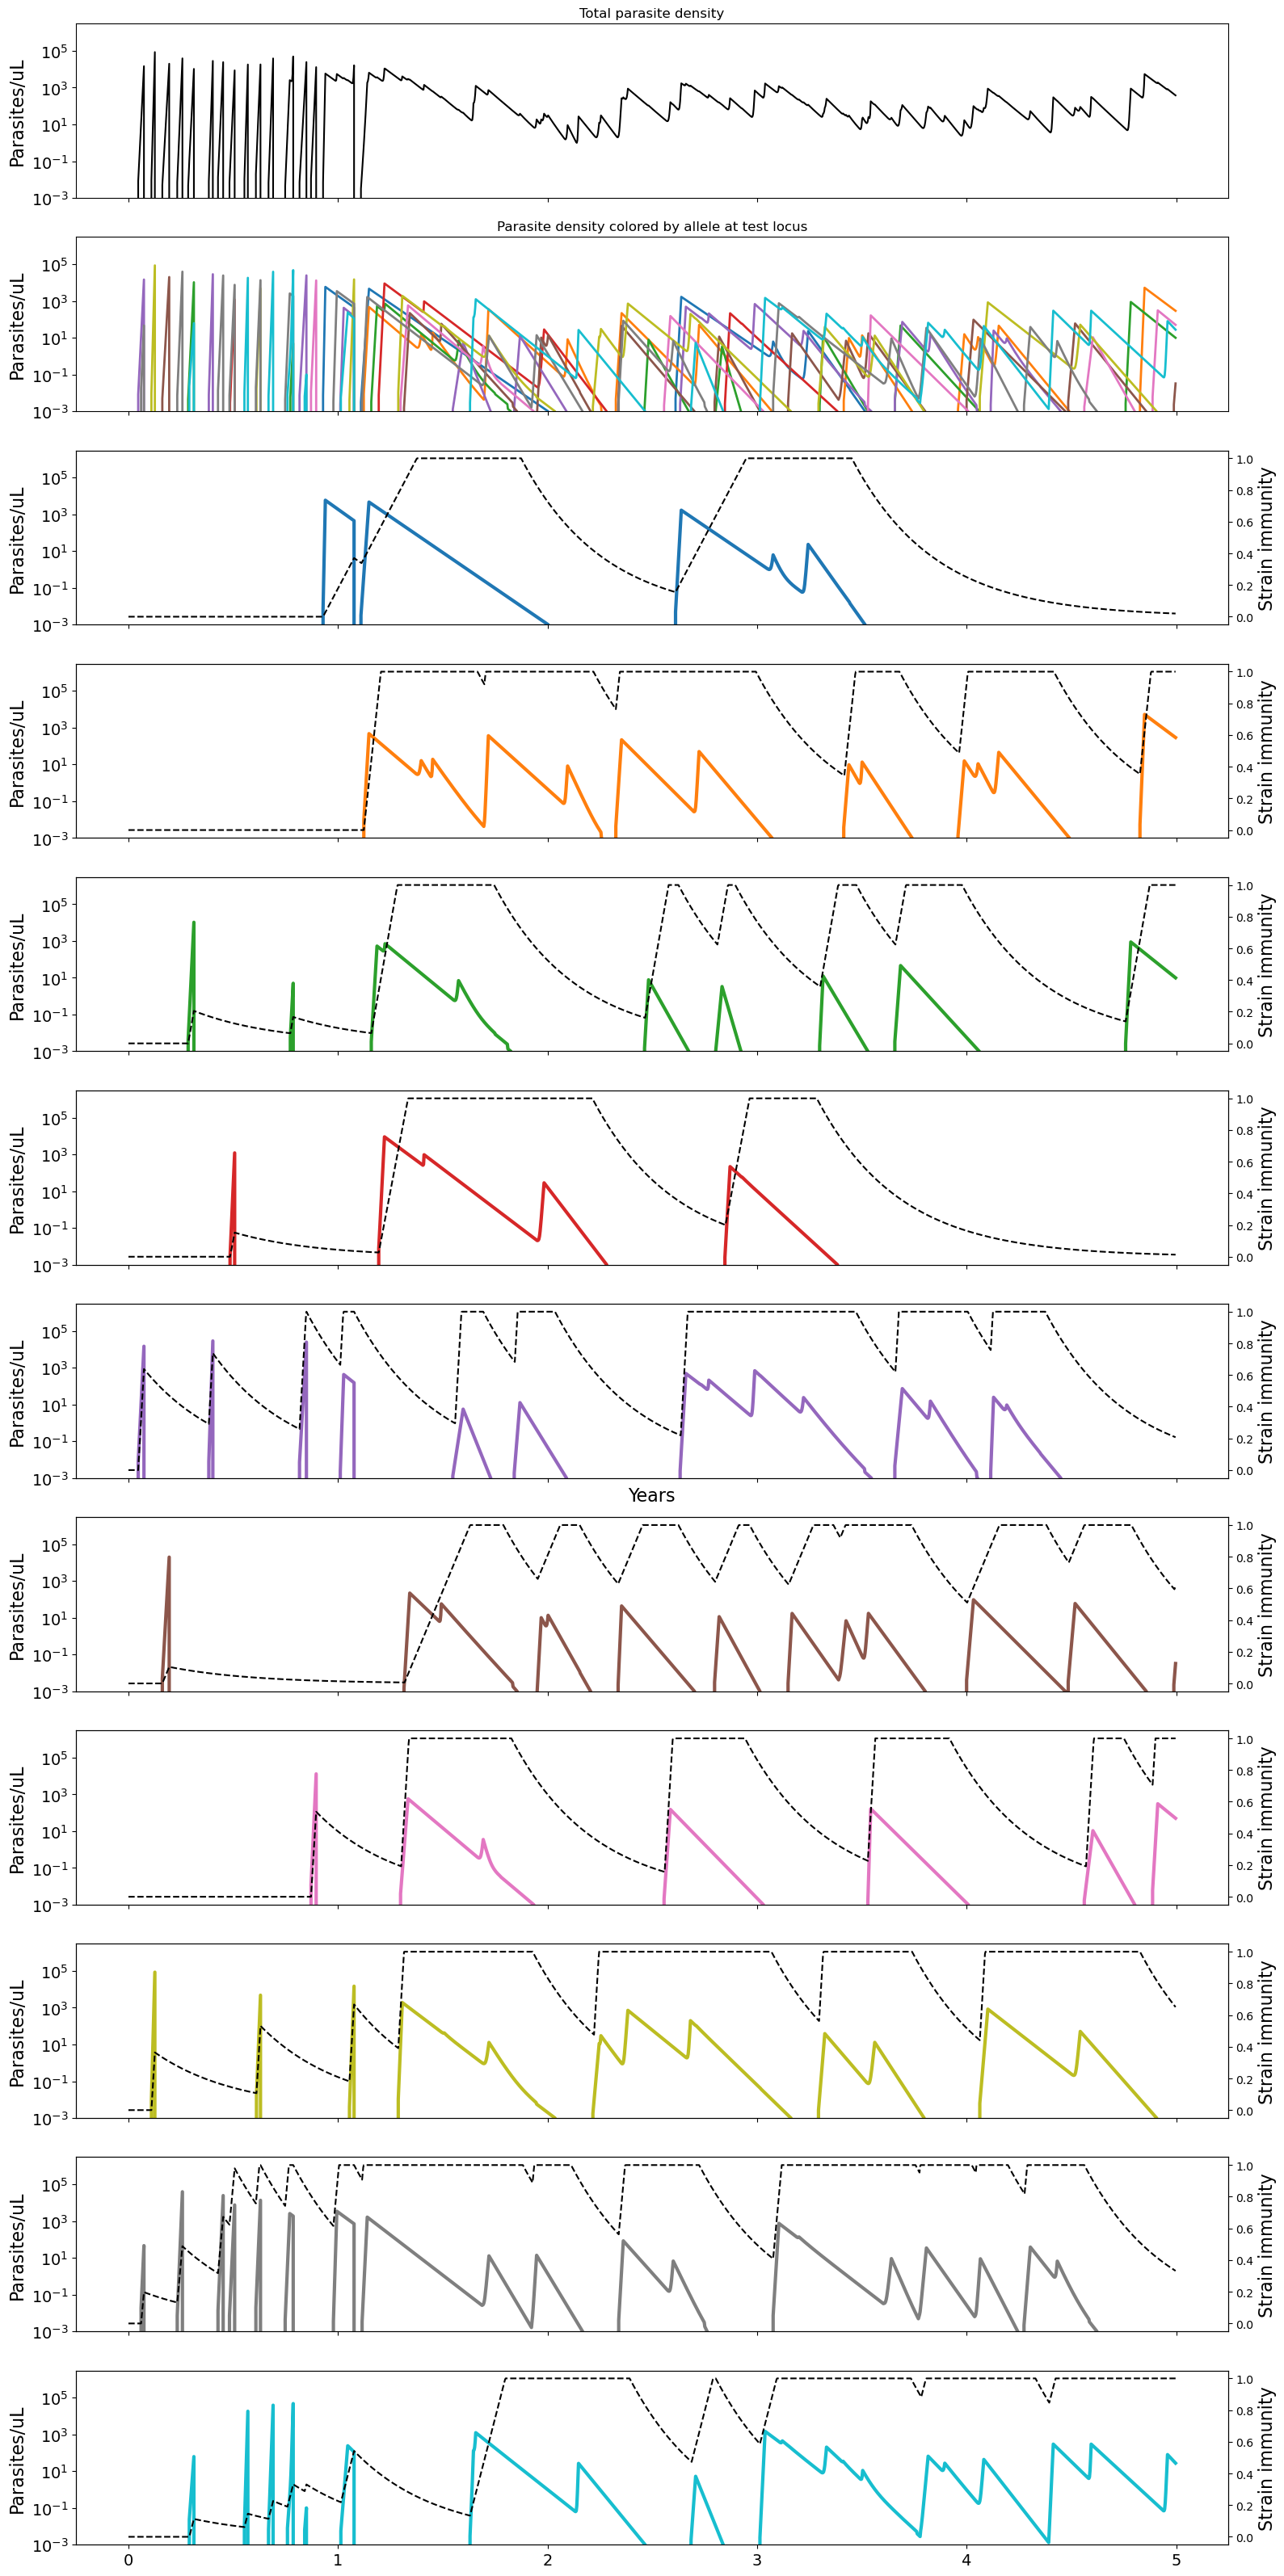

In [73]:
colors = {0:"tab:blue", 1:"tab:orange", 2:"tab:green", 3:"tab:red", 4:"tab:purple", 5:"tab:brown", 6:"tab:pink",7:"tab:olive",8:"tab:grey",9:"tab:cyan"}

fig, ax = plt.subplots(nrows=12, sharey=True, sharex=True, tight_layout=True, figsize=(16,32))
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[0].set_yscale('log')
ax[0].plot(np.arange(y*365)/365, pmatrix[-1,:,:].sum(axis=0),color="black")
for strain in np.arange(a[-1]):
    iStrain = pmatrix[-1,strain,:]
    if np.sum(iStrain) > 1:
        ax[1].plot(np.arange(y*365)/365, iStrain, linewidth=2,color=colors[strain])
ax[0].set_ylim(0.001,3000000)
ax[6].set_xlabel('Years',fontsize=16)
ax[0].set_ylabel('Parasites/uL',fontsize=16)
ax[0].set_title('Total parasite density')
ax[1].set_title('Parasite density colored by allele at test locus')
ax[1].set_ylabel('Parasites/uL',fontsize=16)
for row in range(2,12):
    ax[row].tick_params(axis='both', which='major', labelsize=14)
    ax[row].set_ylabel('Parasites/uL',fontsize=16)
    other = [strain for strain in range(0,5) if strain != row-2]
    ax[row].plot(np.arange(y*365)/365, pmatrix[-1,row-2,:],linewidth=3,color=colors[row-2])
    #ax[row].vlines(x=np.asarray(visits)/365,ymin=0.001,ymax=100000,color="black",linestyle="dashed",linewidth=1)

    #for strain in other:
     #   ax[row].plot(np.arange(y*365)/365, all_parasites[i,-1,strain,:],linewidth=2,alpha=0.2,color=colors[strain])

    ax2 = ax[row].twinx()
    ax2.set_ylabel('Strain immunity',fontsize=16)
    ax2.plot(np.arange(y*365)/365, imatrix[-1,row-2,:],linewidth=1.5,color='black',linestyle='dashed')

In [74]:
all_parasites, all_immunity, all_strains, all_malaria,all_infections = simulate_cohort(n_people,y,a,w,iEffect=0.06,limm=0.5)

Parasite density
min:-2.618342234939238
max:5.3145191810917485
median:2.665578580039693
mean:2.112489313066973
std:1.7647650679727278
---------------------
Infection length
min:1
max:374
median:16.0
mean:68.2912645082468
std:84.35389252745951
---------------------
MOI
min:0
max:15
median:0.0
mean:1.4667567567567568
std:2.6262145751797923
---------------------
% Parasitemia
min:0.16216216216216217
max:0.8108108108108109
median:0.44594594594594594
mean:0.4670270270270271
std:0.15130694329205674
---------------------
Malaria cases per year
min:2.2
max:9.0
median:5.4
mean:5.276
std:1.5919246213310478
---------------------


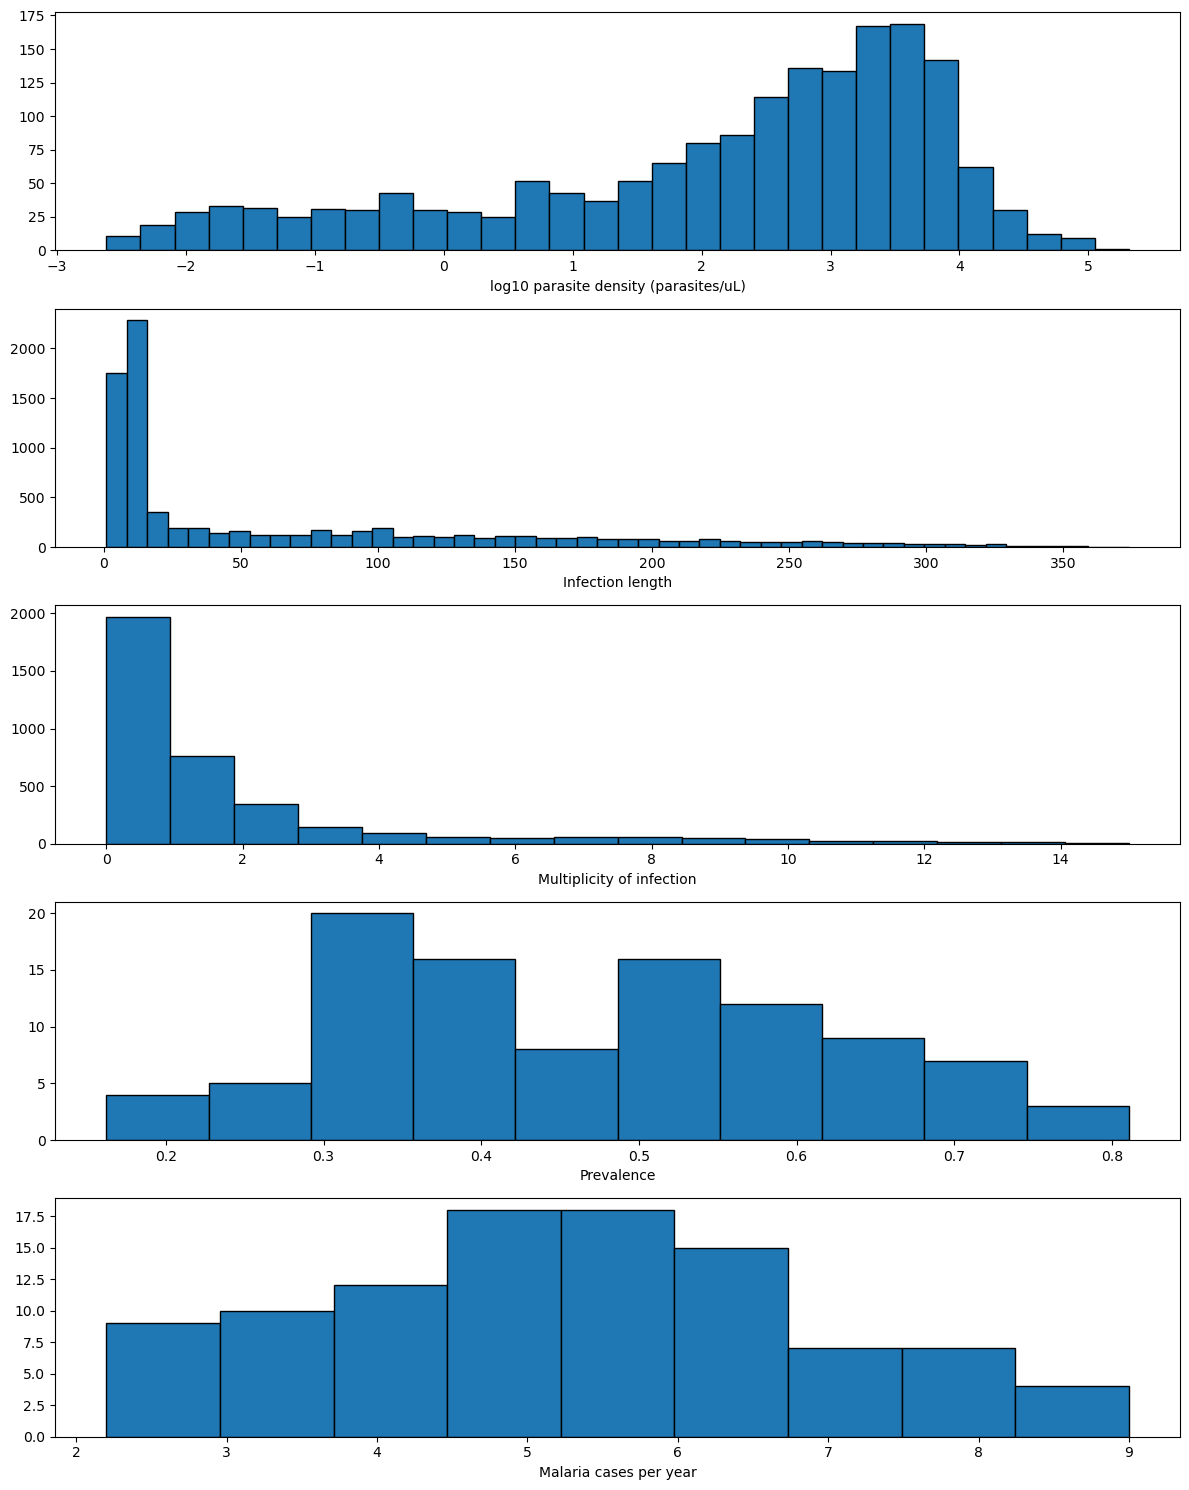

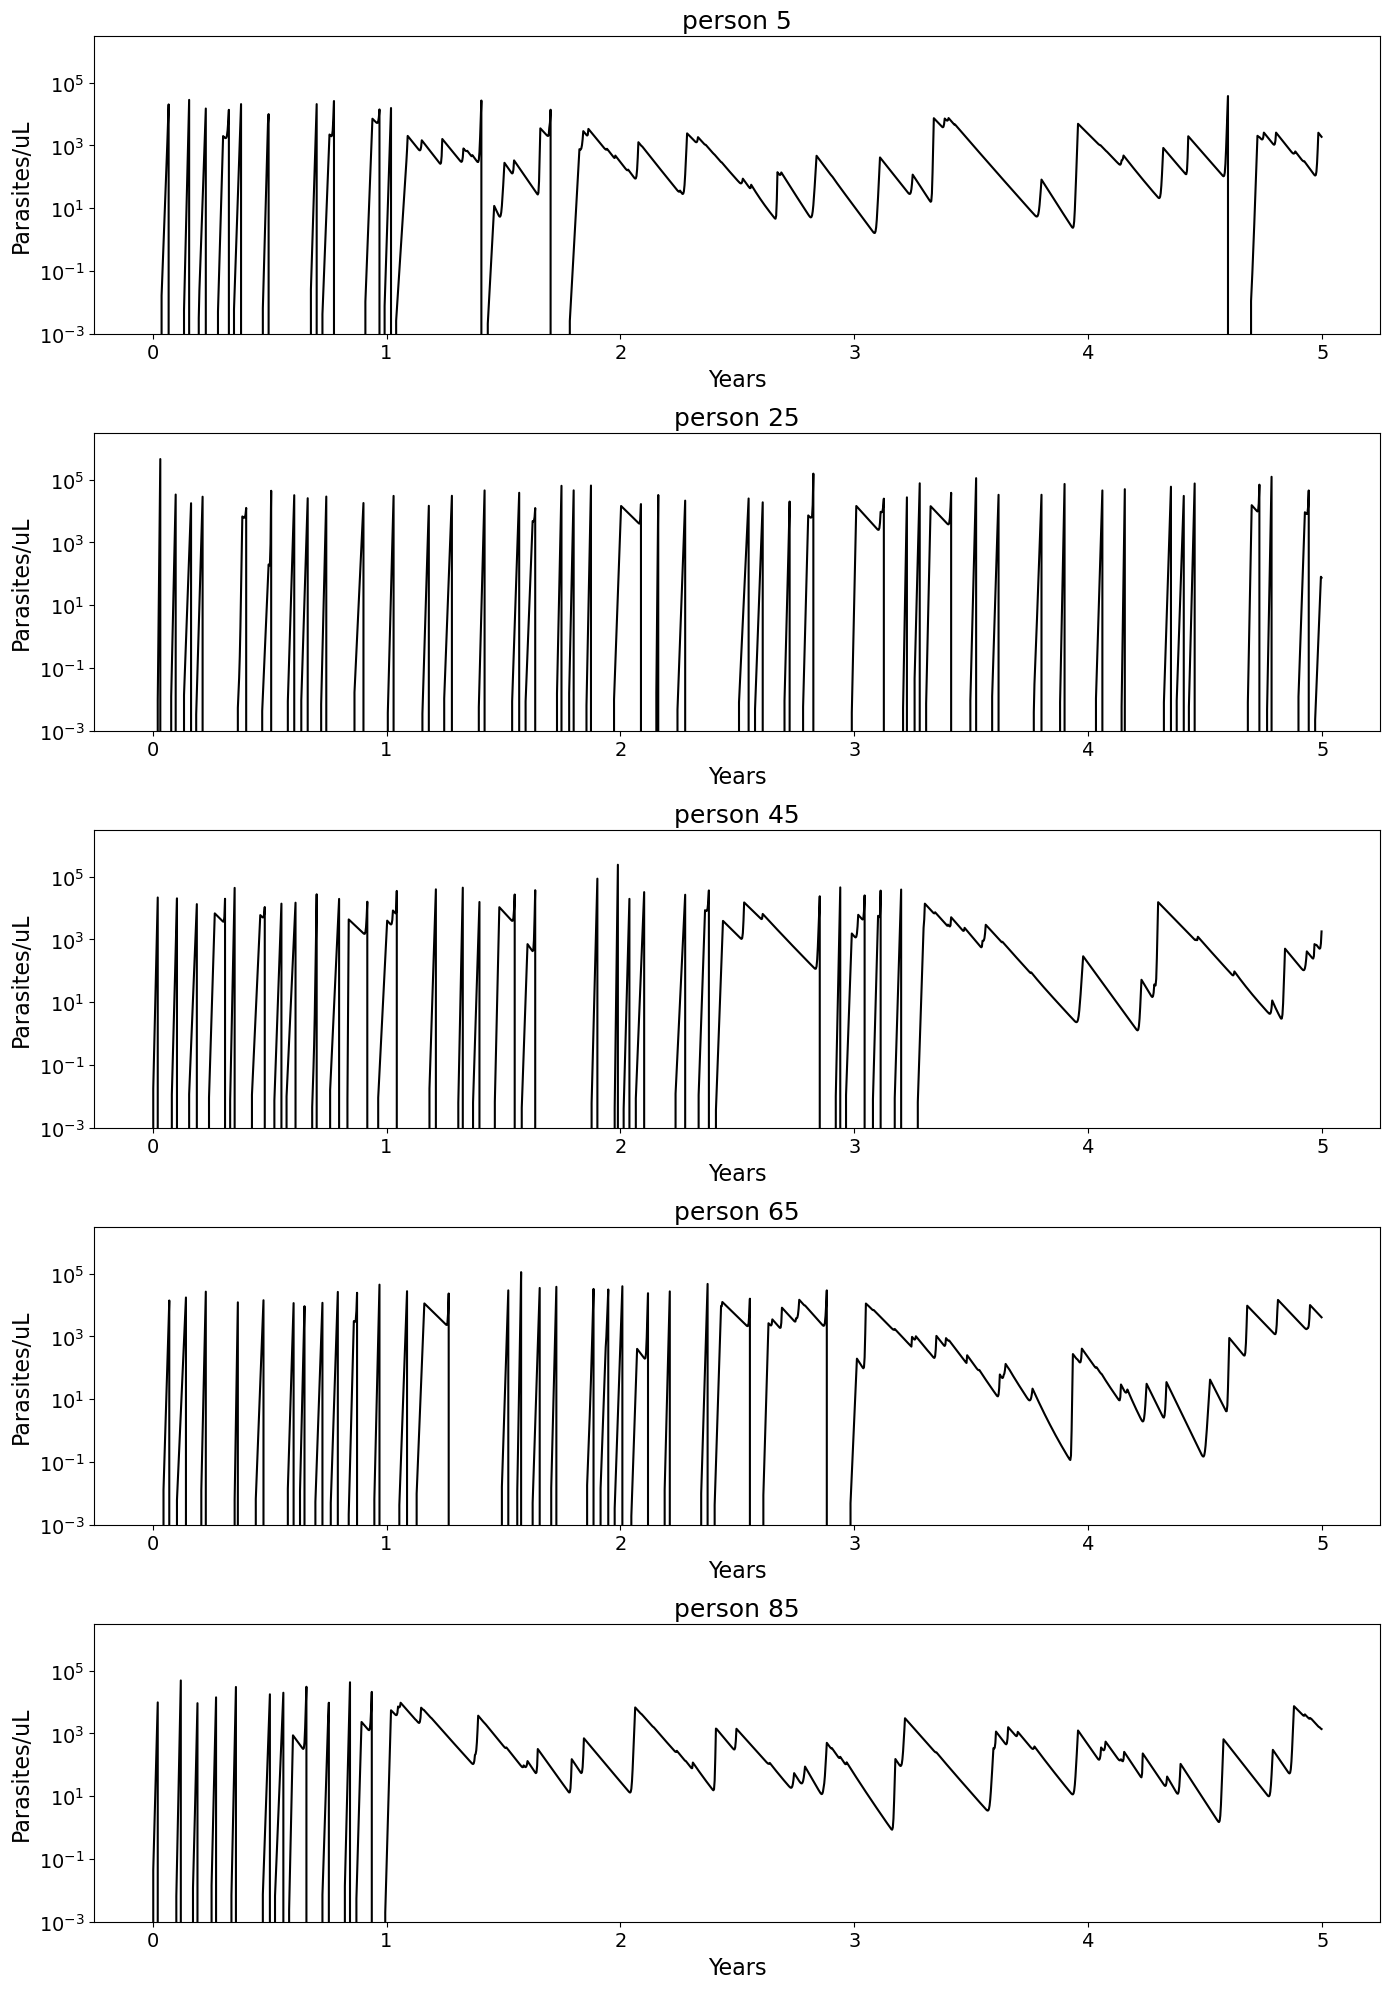

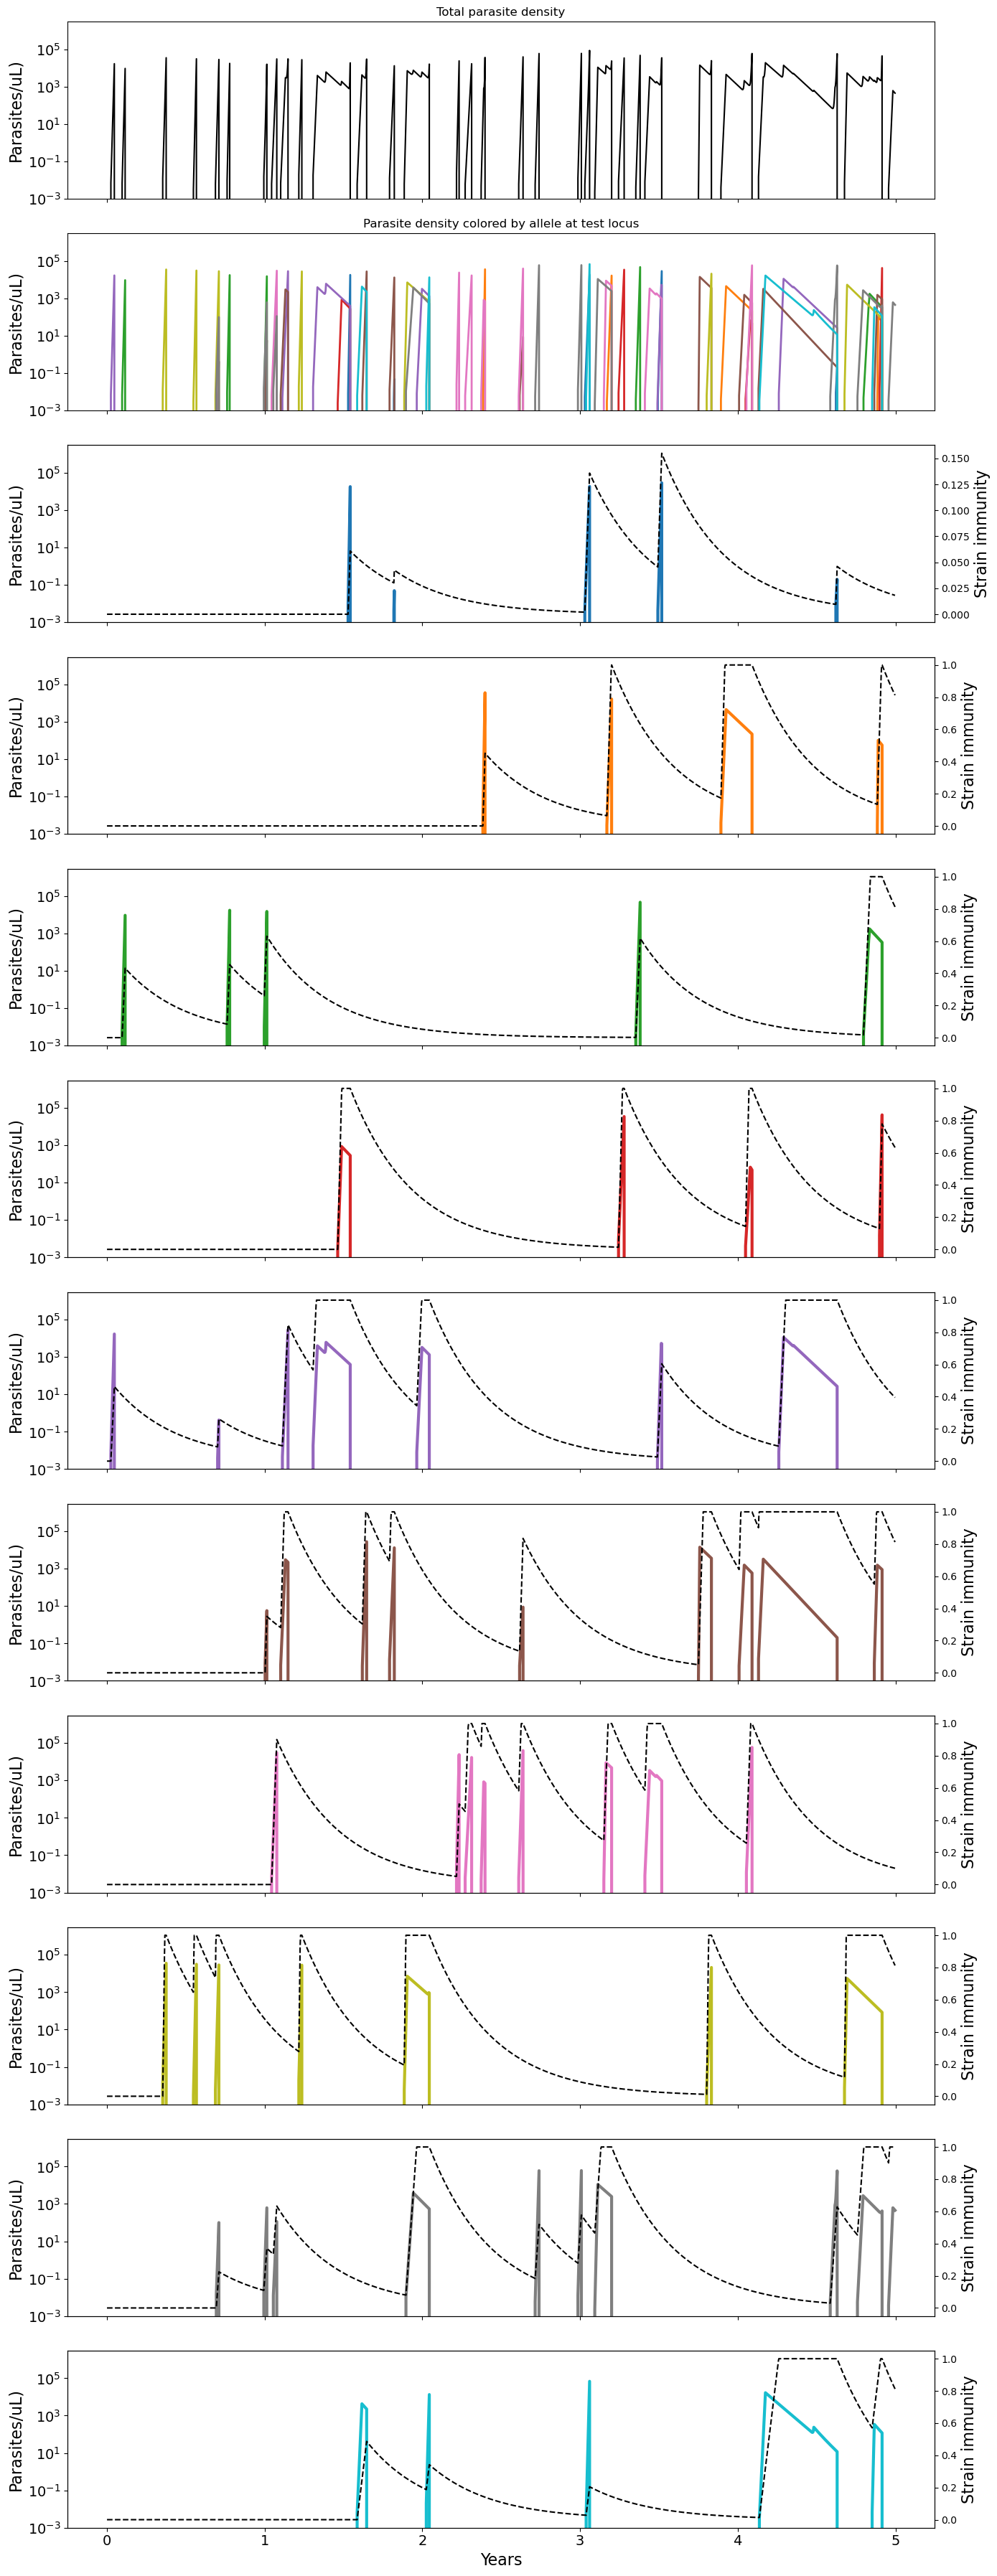

In [75]:
pt.check_outcomes(a,4,all_parasites,all_immunity,all_strains,all_malaria)